In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
!gdown https://drive.google.com/file/d/1lK5UmOnLK8_pFT4V10ZyU0olUZi_FHIw/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1YmQLJjyW-BRAAFAHbk6iwwTwwdNPNNjR/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1lK5UmOnLK8_pFT4V10ZyU0olUZi_FHIw
To: /content/glove.6B.100d.txt
100% 347M/347M [00:03<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YmQLJjyW-BRAAFAHbk6iwwTwwdNPNNjR
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 91.9MB/s]


In [3]:
movie_reviews = pd.read_csv("./IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

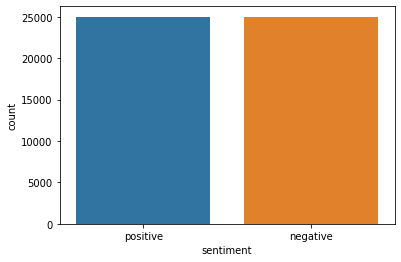

In [6]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [7]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    #sentence = re.sub(r"s+[a-zA-Z]s+", ' ', sentence)

    # Removing multiple spaces
    #sentence = re.sub(r's+', ' ', sentence)

    return sentence

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
X[3]

'Basically there s a family where a little boy  Jake  thinks there s a zombie in his closet   his parents are fighting all the time This movie is slower than a soap opera    and suddenly  Jake decides to become Rambo and kill the zombie OK  first of all when you re going to make a film you must Decide if its a thriller or a drama  As a drama the movie is watchable  Parents are divorcing   arguing like in real life  And then we have Jake with his closet which totally ruins all the film  I expected to see a BOOGEYMAN similar movie  and instead i watched a drama with some meaningless thriller spots   out of    just for the well playing parents   descent dialogs  As for the shots with Jake  just ignore them '

In [11]:
#convierte las etiquetas positivo 1 y negativo 0
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [12]:
#crea datasets de prueba y train, en un 80% para el conjunto de entrenamiento y un 20% para el conjunto de prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Preparación de la capa de incrustación

---



In [13]:
#crear diccionario de palabras a índice (incrustaciones de palabras)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
# matriz de características con incrustaciones Glove
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open("./glove.6B.100d.txt")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype="float32")
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
#matriz de incrustación
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

CLASIFICACIÓN DE UN TEXTO CON UNA RED NEURONAL SIMPLE
---



In [86]:
model = Sequential()
embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)
model.add(embedding_layer)
model.add(Flatten())
#para mejorar se agrega dos capas ocultas 12 y 8 capas, luego se aumenta neuronas en las capas a 32 cada una y luego 16
model.add(Dense(32, activation='relu'))
#quitar una capa
#model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [88]:
#Compilar el modelo usando el optimizador Adam
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          9254700   
                                                                 
 flatten_7 (Flatten)         (None, 10000)             0         
                                                                 
 dense_23 (Dense)            (None, 32)                320032    
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,574,765
Trainable params: 320,065
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [89]:
#Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6632 - acc: 0.6261 - val_loss: 0.6335 - val_acc: 0.7122
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.5819 - acc: 0.7375 - val_loss: 0.5856 - val_acc: 0.7139
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.5286 - acc: 0.7736 - val_loss: 0.5579 - val_acc: 0.7394
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4901 - acc: 0.7959 - val_loss: 0.5649 - val_acc: 0.7350
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4645 - acc: 0.8070 - val_loss: 0.5547 - val_acc: 0.7426
Epoch 6/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4446 - acc: 0.8172 - val_loss: 0.5500 - val_acc: 0.7351


In [90]:
#OPtimización del modelo  
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          9254700   
                                                                 
 flatten_7 (Flatten)         (None, 10000)             0         
                                                                 
 dense_23 (Dense)            (None, 32)                320032    
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,574,765
Trainable params: 320,065
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [91]:
#Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4245 - acc: 0.8264 - val_loss: 0.5592 - val_acc: 0.7385
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4088 - acc: 0.8354 - val_loss: 0.5627 - val_acc: 0.7414
Epoch 3/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4010 - acc: 0.8376 - val_loss: 0.6014 - val_acc: 0.7374
Epoch 4/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3897 - acc: 0.8437 - val_loss: 0.5845 - val_acc: 0.7370
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3789 - acc: 0.8499 - val_loss: 0.6013 - val_acc: 0.7372
Epoch 6/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3738 - acc: 0.8508 - val_loss: 0.6041 - val_acc: 0.7347


In [92]:
#Para evaluar el modelo
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.6207 - acc: 0.7261
Test Score: 0.6207485198974609
Test Accuracy: 0.7261000275611877


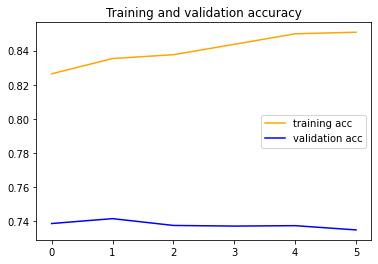

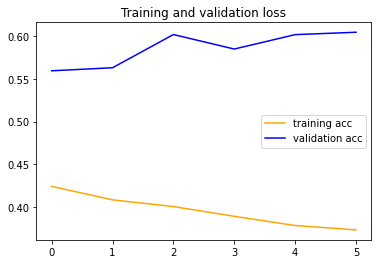

In [93]:
#Gráfica de la pérdida y precisión del modelo
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Clasificación de texto con red neuronal recurrente (LSTM)

---
Una vez más, ejecute el código hasta la sección de incrustación de palabras y luego ejecute el siguiente fragmento de código.


In [75]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
#Compilar el modelo
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['acc'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [76]:
#entrenar el modelo en el conjunto de entrenamiento 
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=6, 
                    verbose=1,
                    validation_split=0.2)
#evalua desempeño en el conjunto de prueba.
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.5690 - acc: 0.6965 - val_loss: 0.4755 - val_acc: 0.7751
Epoch 2/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4548 - acc: 0.7901 - val_loss: 0.4318 - val_acc: 0.8000
Epoch 3/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4162 - acc: 0.8101 - val_loss: 0.3855 - val_acc: 0.8257
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3808 - acc: 0.8290 - val_loss: 0.3671 - val_acc: 0.8391
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3553 - acc: 0.8426 - val_loss: 0.3550 - val_acc: 0.8435
Epoch 6/6
313/313 [==============================] - 1s 4ms/step - loss: 0.3489 - acc: 0.8438


In [77]:
#resultados del modelo
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34889593720436096
Test Accuracy: 0.8438000082969666


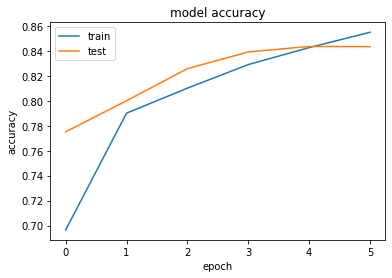

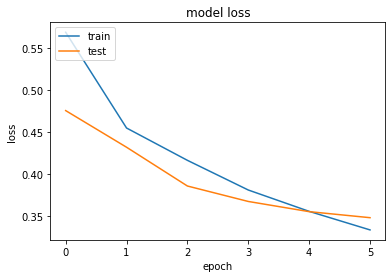

In [78]:
#Tracemos las diferencias de pérdida y precisión entre los conjuntos de entrenamiento y de prueba
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc="upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc="upper left")
plt.show()

CLASIFICACIÓN CON MODELO GRU

---

Ejemplo tomado de http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/RNN_LTSM/introduccion_rnn.html

In [79]:
input_train = X_train
input_test = X_test

In [80]:
from keras.models import Sequential
#from keras import layers
from keras.layers import Dense, GRU, Embedding
model = Sequential()
# Capa embedding
# input_dim : tamaño del vocabulario
# output_dim: dimensión del vector al que se mapea
model.add(Embedding(vocab_size, 100, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))
# comentar la siguiente linea para evaluar dropout 
model.add(GRU(32))
# descomentar la siguiente linea para evaluatr dropout 
#model.add(GRU(32, dropout=.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          9254700   
                                                                 
 gru_1 (GRU)                 (None, 32)                12864     
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,267,597
Trainable params: 12,897
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [81]:
import time
tic = time.time()
history_GRU = model.fit(input_train, y_train,
                        epochs=10,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=2)
print('Tiempo de entrenamiento:', time.time()-tic)

Epoch 1/10
250/250 - 3s - loss: 0.6035 - acc: 0.6578 - val_loss: 0.4893 - val_acc: 0.7648 - 3s/epoch - 14ms/step
Epoch 2/10
250/250 - 2s - loss: 0.4590 - acc: 0.7841 - val_loss: 0.4234 - val_acc: 0.8095 - 2s/epoch - 7ms/step
Epoch 3/10
250/250 - 2s - loss: 0.4131 - acc: 0.8101 - val_loss: 0.3865 - val_acc: 0.8236 - 2s/epoch - 7ms/step
Epoch 4/10
250/250 - 2s - loss: 0.3872 - acc: 0.8243 - val_loss: 0.3802 - val_acc: 0.8255 - 2s/epoch - 7ms/step
Epoch 5/10
250/250 - 2s - loss: 0.3711 - acc: 0.8326 - val_loss: 0.3601 - val_acc: 0.8375 - 2s/epoch - 7ms/step
Epoch 6/10
250/250 - 2s - loss: 0.3583 - acc: 0.8424 - val_loss: 0.3749 - val_acc: 0.8326 - 2s/epoch - 7ms/step
Epoch 7/10
250/250 - 2s - loss: 0.3486 - acc: 0.8458 - val_loss: 0.3679 - val_acc: 0.8313 - 2s/epoch - 7ms/step
Epoch 8/10
250/250 - 2s - loss: 0.3396 - acc: 0.8497 - val_loss: 0.3396 - val_acc: 0.8491 - 2s/epoch - 7ms/step
Epoch 9/10
250/250 - 2s - loss: 0.3311 - acc: 0.8543 - val_loss: 0.3501 - val_acc: 0.8476 - 2s/epoch - 

In [82]:
#resultados del modelo
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34889593720436096
Test Accuracy: 0.8438000082969666


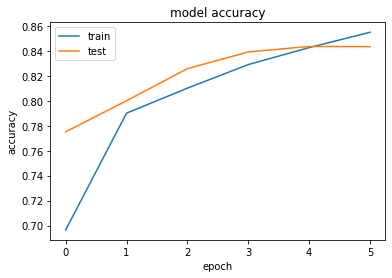

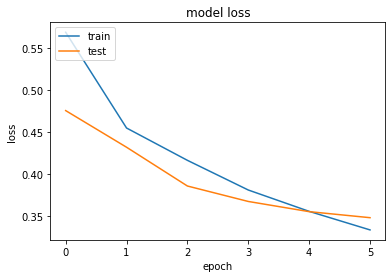

In [83]:
#Tracemos las diferencias de pérdida y precisión entre los conjuntos de entrenamiento y de prueba
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc="upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc="upper left")
plt.show()

 **IMPLEMENTE LA RED RNN SEGÚN EL CÓDIGO INDICADO**

---



**HACER PREDICCIONES DE UNA SOLA INSTANCIA O SENTIMIENTO**

---





In [84]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie  It s so unbelievable  A woman leaves her husband after many years of marriage  has a breakdown in front of a real estate office  What happens  The office manager comes outside and offers her a job    Hilarious  Next thing you know the two women are going at it  Yep  they re lesbians  Nothing rings true in this  Lifetime for Women with nothing better to do  movie  Clunky dialogue like  I don t want to spend the rest of my life feeling like I had a chance to be happy and didn t take it  doesn t help  There s a wealthy  distant mother who disapproves of her daughter s new relationship  A sassy black maid   unbelievable that in the year       a film gets made in which there s a sassy black maid  Hattie McDaniel must be turning in her grave  The woman has a husband who freaks out and wants custody of the snotty teenage kids  Sheesh  No cliche is left unturned 


In [85]:
#Convertir la instancia en números
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

#rellenar la secuencia de entrada como se hizo con el corpus corpus
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
#predecir el sentimiento < a 0.5 --> negativo > a 0.5 positivo
model.predict(instance)

array([[0.80167466]], dtype=float32)

# **EJERCICIOS**
---

**RED NEURONAL SIMPLE:**

Ejercicios:

1.   Pruebe la red con menos o más neuronas en las capas intermedias (4, 8 ... 32, 64, ...)
2.   Intente con mse en lugar de binary_crossentropy
1.   Disminuya las pasadas (epoch) ¿Qué sucede con el sobre ajuste u overfitting?
2.   Retire el batch_size ¿Qué sucede con los tiempos al entrenamiento?


**TAREA ADICIONAL, CÓDIGO RED NEURONAL RNN**

---
Implemente el siguiente código de una red RNN, tome en cuenta que antes de ejecutar el modelo debe ejecutar el código hasta la obtención de la matriz de incrustaciones embedding_matrix

Determine si hay overfiting y realice los ajustes en cuanto a la arquitectura y los hiperparámetros

In [1]:
from keras.layers import SimpleRNN
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# numero de palabras usadas como características
max_features = 10000
# cut off the words after seeing 500 words in each document(email)
#maxlen = 500

#Defina la arquitetura 
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

#Compile el modelo 
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=60, validation_split=0.2)

#Para evaluar el modelo
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

#presenta la gráfica de accuracy y loss
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored